In [9]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Black&Scholes helpers

In [2]:
def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)
def brownian(S0, dt, sigma, mu, z):
    dt_sqrt = tf.math.sqrt(dt)
    shock = sigma * dt_sqrt * z
    drift = (mu - (sigma ** 2) / 2)
    bm = tf.math.exp(drift * dt + shock)
    out = S0 * tf.math.cumprod(bm, axis=1)
    return out

class BlackScholes:
    
    def __init__(self, vol = 0.2, T1 = 1, T2 = 2, K = 1.10, volMult = 1):
        
        self.spot = 1 # S0
        self.vol = vol # sigma
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
    
    def trainingSet(self, m, seed = None):
        
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        X = S1
        Y = pay

        # pathwise differentials
        Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas  

In [7]:
generator = BlackScholes()
nPath = 10000
simulSeed = 1212
nTest = 100

In [24]:
print("simulating training, valid and test sets")
xTrain, yTrain, dydxTrain = generator.trainingSet(nPath, seed=simulSeed)
# xTrain = S(T1) --> Array con tutti i punti Montecarlo corrispondenti al timestep T1 
# per l'unico risk factor S
# yTrain --> è il payoff(T2) = S(T2) - K
# dydxTrain --> sensitivity al risk factor S(T1) = Delta(S(T1))
yTrain_differential = np.array([yTrain[:,0], dydxTrain[:,0]]).T

# TEST SET
xTest, xAxis, yTest, dydxTest, vegas = generator.testSet(num=nTest, seed= None)
# xTest = xAxis --> vettore di spot al tempo T1, S(T1)
# yTest --> vettore di prezzi esatti in T1 con input S(T1)
# dydxTest --> vettore di Delta esatti in T1 con input S(T1)
print("done")

simulating training, valid and test sets
done


#### ANN setup

In [32]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                   solver='adam', shuffle = False, batch_size=64, verbose=True,
                   max_iter= 20
                    )
mlp_differential = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                   solver='adam', shuffle = False, batch_size=64, verbose=True,
                   max_iter= 20
                    )

In [33]:
mlp.fit(xTrain, yTrain[:,0])

Iteration 1, loss = 0.00986203
Iteration 2, loss = 0.00901568
Iteration 3, loss = 0.00906981
Iteration 4, loss = 0.00902979
Iteration 5, loss = 0.00904797
Iteration 6, loss = 0.00908133
Iteration 7, loss = 0.00893452
Iteration 8, loss = 0.00886374
Iteration 9, loss = 0.00887542
Iteration 10, loss = 0.00888230
Iteration 11, loss = 0.00895138
Iteration 12, loss = 0.00887931
Iteration 13, loss = 0.00891458
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(activation='relu', alpha=0.0001, batch_size=64, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=False, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [34]:
mlp_differential.fit(xTrain, yTrain_differential)

Iteration 1, loss = 0.06727010
Iteration 2, loss = 0.06197047
Iteration 3, loss = 0.06212399
Iteration 4, loss = 0.06245124
Iteration 5, loss = 0.06151555
Iteration 6, loss = 0.06194831
Iteration 7, loss = 0.06163430
Iteration 8, loss = 0.06181783
Iteration 9, loss = 0.06170139
Iteration 10, loss = 0.06163220
Iteration 11, loss = 0.06163214
Iteration 12, loss = 0.06153937
Iteration 13, loss = 0.06175609
Iteration 14, loss = 0.06161404
Iteration 15, loss = 0.06200125
Iteration 16, loss = 0.06166870
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(activation='relu', alpha=0.0001, batch_size=64, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=False, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [35]:
predictions = mlp.predict(xTest)
predictions_diff = mlp_differential.predict(xTest);

Text(0.5, 1.0, 'Price differential ML')

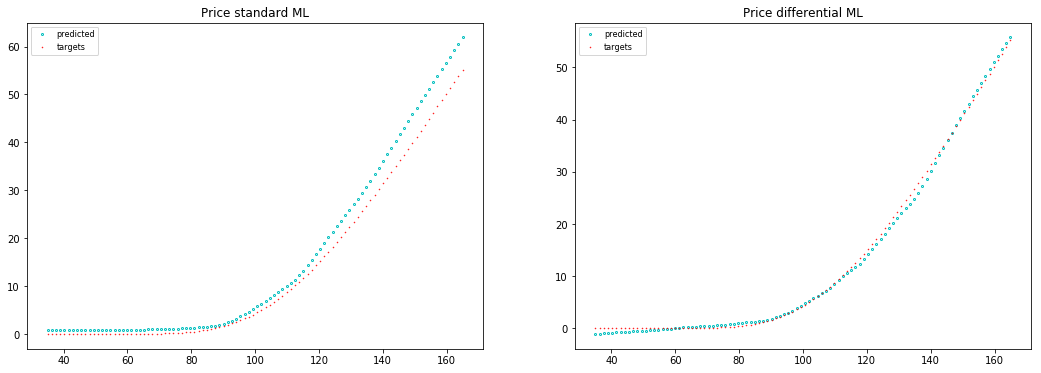

In [43]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(xAxis*100, predictions*100, 'co', \
                       markersize=2, markerfacecolor='white', label="predicted")
ax[1].plot(xAxis*100, predictions_diff[:,0]*100, 'co', \
                       markersize=2, markerfacecolor='white', label="predicted")
ax[0].plot(xAxis*100, yTest*100, 'r.', markersize=1, label='targets')
ax[1].plot(xAxis*100, yTest*100, 'r.', markersize=1, label='targets')
ax[0].legend(prop={'size': 8}, loc='upper left')
ax[1].legend(prop={'size': 8}, loc='upper left')
ax[0].set_title("Price standard ML") 
ax[1].set_title("Price differential ML")

Text(0.5, 1.0, 'Delta differential ML')

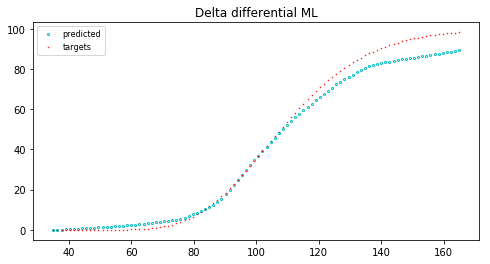

In [53]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(xAxis*100, predictions_diff[:,1]*100, 'co', \
                       markersize=2, markerfacecolor='white', label="predicted")
ax.plot(xAxis*100, dydxTest*100, 'r.', markersize=1, label='targets')
ax.legend(prop={'size': 8}, loc='upper left')
ax.set_title("Delta differential ML")